# 02__cleaner_index

in this notebook, i clean up my original index file to add some additional columns and update some information (e.g. biotype classifications).

figures in this notebook:
- Fig S5D_1: count of biotypes in original library design

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri_with_primers.txt"

In [4]:
# rna seq file has biotype information
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [5]:
endo_ctrls_validated_f = "../../../misc/04__pos_ctrls/endo_ctrls_validated.updated.txt"

## 1. import data

In [6]:
index = pd.read_table(index_f, sep="\t")
print(len(index))
index.head()

111801


,sgRNA,count,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,sgRNA_qual,cut_offset,rank,sgRNA_id,ctrl_status,oligo,oligo_len
0,TTGCAAGTGTCTTTAAACTA,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,225.0,1.0,sgRNA:104025__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTTGCAAGTGTCTTTAA...,85
1,ATTGCAAGTGTCTTTAAACT,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,224.0,2.0,sgRNA:027184__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGATTGCAAGTGTCTTTA...,85
2,AGCCAGTATCTTGAAACTAT,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,199.0,3.0,sgRNA:017196__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGAGCCAGTATCTTGAAA...,85
3,TGCCAATAGTTTCAAGATAC,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,190.0,4.0,sgRNA:095459__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTGCCAATAGTTTCAAG...,85
4,ACAGTAGTGTATCTAAATGG,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,290.0,5.0,sgRNA:009695__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGACAGTAGTGTATCTAA...,85


In [7]:
rna_seq = pd.read_table(rna_seq_f, sep="\t")
print(len(rna_seq))
rna_seq.head()

170623


,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


In [8]:
endo_ctrls_validated = pd.read_table(endo_ctrls_validated_f, sep="\t", header=None)
endo_ctrls_validated.head()

,0
0,ACVR1B
1,BMP2
2,CDH2
3,CER1
4,DUSP4


## 2. un de-dupe index file such that each transcript has its own row
since group ids may target multiple transcripts, but biotypes are assigned at transcript level

In [9]:
# fix index ID columns that can have duplicates in them due to previous aggregation
index["gene_id"] = index.apply(fix_id_dupes, column="gene_id", axis=1)
index["gene_name"] = index.apply(fix_id_dupes, column="gene_name", axis=1)
index["transcript_id"] = index.apply(fix_id_dupes, column="transcript_id", axis=1)
index["transcript_name"] = index.apply(fix_id_dupes, column="transcript_name", axis=1)
index = index.drop_duplicates()
len(index.transcript_id.unique())

10851

In [10]:
index_sub = index[["tss_id_hg38", "gene_name", "gene_id", "transcript_name", "transcript_id"]].drop_duplicates()
print(len(index_sub))
print(len(index_sub.tss_id_hg38.unique()))
index_sub.head()

10853
10853


,tss_id_hg38,gene_name,gene_id,transcript_name,transcript_id
0,NC_000001.11:-:100084320,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1
10,NC_000001.11:-:100266115,RTCA-AS1,ENSG00000224616.1_1,RTCA-AS1-001,ENST00000421185.1_1
20,NC_000001.11:+:100894913,RP4-549L20.3,ENSG00000273204.1_1,RP4-549L20.3-001,ENST00000609247.1_1
30,NC_000001.11:+:100995473,RP11-421L21.2,ENSG00000235795.1_1,RP11-421L21.2-001,ENST00000414686.1_1
40,NC_000001.11:+:101025906,RP11-421L21.3,ENSG00000233184.6_1,"['RP11-421L21.3-005', 'RP11-421L21.3-004']","['ENST00000446527.5_1', 'ENST00000453011.5_1']"


In [11]:
print(len(index_sub))
index_sub_split = tidy_split(index_sub, "transcript_id", sep=",", keep=False)
print(len(index_sub_split))
index_sub_split["transcript_id"] = index_sub_split["transcript_id"].str.replace('[', '')
index_sub_split["transcript_id"] = index_sub_split["transcript_id"].str.replace(']', '')
index_sub_split["transcript_id"] = index_sub_split["transcript_id"].str.replace(' ', '')
index_sub_split["transcript_id"] = index_sub_split["transcript_id"].str.replace("'", '')
index_sub_split.drop(["gene_name", "gene_id", "transcript_name"], axis=1, inplace=True)
index_sub_split.head(10)

10853
13250


,tss_id_hg38,transcript_id
0,NC_000001.11:-:100084320,ENST00000432294.1_1
10,NC_000001.11:-:100266115,ENST00000421185.1_1
20,NC_000001.11:+:100894913,ENST00000609247.1_1
30,NC_000001.11:+:100995473,ENST00000414686.1_1
40,NC_000001.11:+:101025906,ENST00000446527.5_1
40,NC_000001.11:+:101025906,ENST00000453011.5_1
48,NC_000001.11:+:101072856,ENST00000454721.5_1
48,NC_000001.11:+:101072856,ENST00000449473.2_1
57,NC_000001.11:+:101081966,ENST00000451213.1_1
67,NC_000001.11:-:101236615,ENST00000432195.1_1


## 3. join un de-duped index w/ rna seq file

In [12]:
index_sub_split = index_sub_split.merge(rna_seq, on="transcript_id", how="left")
print(len(index_sub_split))
index_sub_split.head()

13250


,tss_id_hg38,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,NC_000001.11:-:100084320,ENST00000432294.1_1,ENSG00000241073.1_2,RP4-714D9.2,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.000000,0.000000,0.000000,...,1.175084,0.000000,0.000000,1.405577,0.468526,expressed,sleuth NA,0.0208542554784637,0.000000,1.266383
1,NC_000001.11:-:100266115,ENST00000421185.1_1,ENSG00000224616.1_1,RTCA-AS1,lncRNA_good_csf,promoter_overlap,promoter_overlap,1.205757,1.463212,2.509027,...,1.314707,1.334485,3.027785,1.297216,1.886495,expressed,0.0505181706555853,0.0794802476570829,0.786883,-0.023217
2,NC_000001.11:+:100894913,ENST00000609247.1_1,ENSG00000273204.1_1,RP4-549L20.3,lncRNA_good_csf,transcript_overlap,promoter_overlap,0.000000,0.000000,0.000000,...,2.004291,0.000000,0.000000,1.002145,0.334048,expressed,sleuth NA,sleuth NA,0.000000,1.001547
3,NC_000001.11:+:100995473,ENST00000414686.1_1,ENSG00000235795.1_1,RP11-421L21.2,lncRNA_good_csf,transcript_overlap,promoter_overlap,0.377425,0.152806,0.294236,...,0.261710,0.265116,0.404653,0.252168,0.307312,expressed,0.205607380239519,0.0852909336145518,0.150945,-0.014841
4,NC_000001.11:+:101025906,ENST00000446527.5_1,ENSG00000233184.6_1,RP11-421L21.3,lncRNA_good_csf,promoter_overlap,promoter_overlap,1.977835,1.937615,1.169082,...,6.634660,1.957725,1.186426,5.476837,2.873663,expressed,0.0382314534972833,0.0236097713681433,-0.435913,1.130801


## 4. aggregate back to tss level: collapse csf column, biotype columns

In [13]:
index_sub_tmp = index_sub_split.groupby("tss_id_hg38")[["csf", 
                                                        "cleaner_gene_biotype", 
                                                        "cleaner_transcript_biotype"]].agg(set).reset_index()
index_sub_tmp.head()

,tss_id_hg38,csf,cleaner_gene_biotype,cleaner_transcript_biotype
0,NC_000001.11:+:100894913,{lncRNA_good_csf},{transcript_overlap},{promoter_overlap}
1,NC_000001.11:+:100995473,{lncRNA_good_csf},{transcript_overlap},{promoter_overlap}
2,NC_000001.11:+:101025906,{lncRNA_good_csf},{promoter_overlap},{promoter_overlap}
3,NC_000001.11:+:101072856,{lncRNA_good_csf},{promoter_overlap},{intergenic}
4,NC_000001.11:+:101081966,{lncRNA_good_csf},{promoter_overlap},{intergenic}


In [14]:
def dedup_status(row, col):
    vals = row[col]
    if len(vals) == 1:
        return list(vals)[0]
    else:
        return "multi-targeting"
    
index_sub_tmp["csf_status"] = index_sub_tmp.apply(dedup_status, axis=1, col="csf")
index_sub_tmp["gene_biotype_status"] = index_sub_tmp.apply(dedup_status, axis=1, col="cleaner_gene_biotype")
index_sub_tmp["transcript_biotype_status"] = index_sub_tmp.apply(dedup_status, axis=1, col="cleaner_transcript_biotype")

In [15]:
len(index_sub_tmp)

10853

## 5. join back to original file

In [16]:
index = index.merge(index_sub_tmp[["tss_id_hg38", "csf_status", "gene_biotype_status",
                                   "transcript_biotype_status"]], on="tss_id_hg38", how="left")
len(index)

111801

## 6. fix control status column

In [17]:
val_ctrls = list(endo_ctrls_validated[0])
len(val_ctrls)

23

In [18]:
def fix_ctrl_status(row):
    if row.gene_name in val_ctrls:
        return "control"
    else:
        if row.gene_name == "scramble":
            return "scramble"
        elif row.gene_biotype_status == "protein_coding":
            return "mRNA"
        else:
            return "experimental"

In [19]:
index["ctrl_status_fixed"] = index.apply(fix_ctrl_status, axis=1)

## 7. output counts

In [20]:
print(" === COUNT OF GUIDES === ")
print("")
index.ctrl_status_fixed.value_counts()

 === COUNT OF GUIDES === 



experimental    103859
scramble          5000
mRNA              2702
control            240
Name: ctrl_status_fixed, dtype: int64

In [21]:
print(" === COUNT OF TSSS ===")
print("")
index.drop_duplicates(subset="tss_id_hg38").ctrl_status_fixed.value_counts()

 === COUNT OF TSSS ===



experimental    10556
mRNA              272
control            24
scramble            1
Name: ctrl_status_fixed, dtype: int64

## 8. plot biotypes

In [22]:
index_lncrna = index[index["ctrl_status_fixed"] == "experimental"]
len(index_lncrna)

103859

In [23]:
index_lncrna = index_lncrna[["tss_id_hg38", "transcript_biotype_status"]].drop_duplicates()
len(index_lncrna)

10556

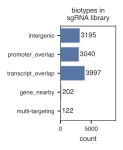

In [24]:
fig = plt.figure(figsize=(1, 1.75))

order = ["intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby", "multi-targeting"]
ax = sns.countplot(data=index_lncrna, y="transcript_biotype_status", order=order, color=sns.color_palette()[0])

for p in ax.patches:
    w = p.get_width()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(w + 100, y + h/2, int(w), ha="left", va="center", fontsize=fontsize) 
    
plt.xlim((0,9000))
plt.ylabel("")
plt.title("biotypes in\nsgRNA library")
fig.savefig("FigS5D_1.pdf", dpi="figure", bbox_inches="tight")

## 9. write cleaner index file

In [25]:
len(index)

111801

In [26]:
index.head()

,sgRNA,count,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,sgRNA_qual,cut_offset,rank,sgRNA_id,ctrl_status,oligo,oligo_len,csf_status,gene_biotype_status,transcript_biotype_status,ctrl_status_fixed
0,TTGCAAGTGTCTTTAAACTA,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,225.0,1.0,sgRNA:104025__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTTGCAAGTGTCTTTAA...,85,lncRNA_good_csf,transcript_overlap,transcript_overlap,experimental
1,ATTGCAAGTGTCTTTAAACT,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,224.0,2.0,sgRNA:027184__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGATTGCAAGTGTCTTTA...,85,lncRNA_good_csf,transcript_overlap,transcript_overlap,experimental
2,AGCCAGTATCTTGAAACTAT,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,199.0,3.0,sgRNA:017196__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGAGCCAGTATCTTGAAA...,85,lncRNA_good_csf,transcript_overlap,transcript_overlap,experimental
3,TGCCAATAGTTTCAAGATAC,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,190.0,4.0,sgRNA:095459__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGTGCCAATAGTTTCAAG...,85,lncRNA_good_csf,transcript_overlap,transcript_overlap,experimental
4,ACAGTAGTGTATCTAAATGG,1,NC_000001.11:-:100084320,ENST00000432294.1_1,RP4-714D9.2-001,ENSG00000241073.1_2,RP4-714D9.2,FANTOM CAT assignment,"chr1:100549872..100549883,-",good,290.0,5.0,sgRNA:009695__gene:RP4-714D9.2,experimental,TCACAACTACACCAGAAGCCACCTTGTTGGACAGTAGTGTATCTAA...,85,lncRNA_good_csf,transcript_overlap,transcript_overlap,experimental


In [27]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri.clean_index.txt"
index.to_csv(index_f, sep="\t", index=False)